In [25]:
import warnings

import numpy as np
from sklearn.tree import export_graphviz

warnings.simplefilter(action='ignore')

import pandas as pd
import seaborn as sns
import missingno as msno
from missingpy import MissForest
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier, plot_importance
from xgboost import plot_tree

sns.set(rc={'figure.figsize':(10, 8)})

In [2]:
df = pd.read_csv('train_music.csv', sep =',')
df

,id,target,device_type,manufacturer_category,os_category,sim_count,tp_flag,lt,block_flag,days_exp,...,service_5_count_m3,service_6_count_m3,service_7_cost_m3,service_7_flag_m3,service_8_count_m3,income_brnd_cont_m3,data_type_1_m3,data_type_2_m3,data_type_3_m3,service_9_flag_m3
0,48104912810,0,7,1514,3,1.0,0,0.496508,0,299.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,13762.315646,1292.468784,NaN
1,4851497268,0,4,896,28,1.0,0,0.881540,0,189.0,...,11.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.000053,NaN
2,4877823097,0,7,592,3,2.0,0,0.811192,0,347.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.000977,NaN
3,4830183791,0,7,1756,3,2.0,0,0.928449,1,343.0,...,66.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.006680,NaN
4,48103940036,0,4,1057,28,1.0,0,0.578654,0,355.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.002487,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,4819141039,0,7,812,3,2.0,0,0.963514,0,357.0,...,65.0,0.0,0.0,0.0,0.0,NaN,NaN,815.758405,54.737625,NaN
69996,4888452526,0,7,1057,3,1.0,1,0.777850,0,364.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
69997,4812460312,0,7,745,3,2.0,0,0.980984,0,363.0,...,54.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
69998,4890036665,0,7,56,3,1.0,0,0.770969,0,341.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1832.938670,72.373650,NaN


In [3]:
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 461 entries, id to service_9_flag_m3
dtypes: float64(452), int64(9)
memory usage: 246.2 MB


In [4]:
df = df.sample(n = 20000, random_state=42)
df

,id,target,device_type,manufacturer_category,os_category,sim_count,tp_flag,lt,block_flag,days_exp,...,service_5_count_m3,service_6_count_m3,service_7_cost_m3,service_7_flag_m3,service_8_count_m3,income_brnd_cont_m3,data_type_1_m3,data_type_2_m3,data_type_3_m3,service_9_flag_m3
46730,48101197942,0,7,592,3,2.0,0,0.632435,0,108.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,716.420311,NaN,NaN
48393,48104251257,0,7,1057,3,2.0,0,0.540345,0,330.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,80.144736,14.630618,NaN
41416,4811813104,0,7,1057,3,2.0,0,0.951582,0,344.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.018959,0.000977,57.100249,NaN
34506,48101053138,0,7,745,3,2.0,0,0.659047,0,361.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
43725,4830019330,0,7,1057,3,2.0,0,0.926471,0,199.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1989.913944,29.685412,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63473,4894477348,1,7,1057,3,2.0,0,0.707827,0,221.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
66494,4875984633,0,7,592,3,2.0,0,0.824135,0,355.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,5979.779220,265.482364,NaN
56986,4811247711,0,7,728,3,1.0,0,0.924764,0,208.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
43542,4896164388,0,7,1057,3,2.0,0,0.716732,0,324.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,28.008975,10.813313,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 46730 to 59369
Columns: 461 entries, id to service_9_flag_m3
dtypes: float64(452), int64(9)
memory usage: 70.5 MB


In [6]:
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
id,20000.0,1.306414e+10,1.719221e+10,4.825674e+08,4.832647e+09,4.872661e+09,4.897139e+09,4.810855e+10
target,20000.0,7.480000e-02,2.630749e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
device_type,20000.0,6.529000e+00,1.201970e+00,1.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,8.000000e+00
manufacturer_category,20000.0,8.895698e+02,4.940030e+02,1.000000e+00,5.920000e+02,8.960000e+02,1.057000e+03,1.836000e+03
os_category,20000.0,7.733400e+00,9.564214e+00,1.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,2.800000e+01
...,...,...,...,...,...,...,...,...
income_brnd_cont_m3,2654.0,1.789848e+01,7.412896e+01,7.843000e-01,2.745100e+00,8.329400e+00,1.950978e+01,3.001067e+03
data_type_1_m3,2359.0,2.319182e+03,5.695641e+03,1.325607e-04,5.390087e+01,4.940910e+02,2.052402e+03,7.218172e+04
data_type_2_m3,12782.0,2.796011e+03,6.620885e+03,4.959106e-05,1.303041e+02,6.685948e+02,2.463017e+03,2.751830e+05
data_type_3_m3,14299.0,3.689081e+02,1.061644e+03,3.051758e-05,4.845811e+00,5.673287e+01,3.009783e+02,3.355381e+04


In [7]:
s = df.isna().sum()
nan = pd.DataFrame(data = s[s != 0].sort_values(ascending=False), columns=['Total NaN count'])
nan['Percent'] = df.isna().mean() * 100.0

nan.T

,count_url_category_13,count_url_category_15,count_app_3,vol_app_3,count_url_category_12,vol_app_11,count_app_11,count_url_category_1,rr_gift_type_4,count_gift_type_4,...,service_6_count_m2,short_in_calls_part_m3,service_5_count_m2,paym_el_sum_m1,paym_el_count_m1,act_days_count_m1,abon_part_m1,service_6_count_m1,paym_el_sum_m3,paym_el_sum_m2
Total NaN count,19853.000,19760.0,19719.000,19719.000,19644.00,19546.00,19546.00,19450.00,19425.000,19425.000,...,3.000,3.000,3.000,3.000,3.000,3.000,3.000,3.000,3.000,3.000
Percent,99.265,98.8,98.595,98.595,98.22,97.73,97.73,97.25,97.125,97.125,...,0.015,0.015,0.015,0.015,0.015,0.015,0.015,0.015,0.015,0.015


Ситуация с null ужасна, перед тем как делать окончательные выводы, посмотрим что у нас с балансом.

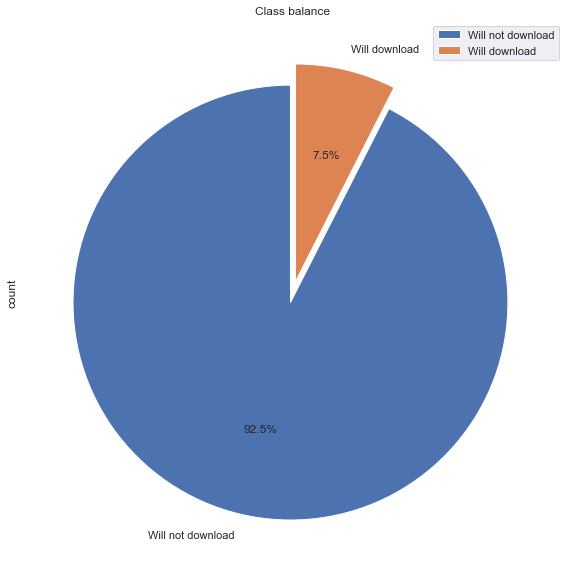

In [13]:
figure, ax = plt.subplots(figsize=(10, 10))

ax.set_title("Class balance")

pd.DataFrame(
    {'count': [df['target'].isin([0]).sum(),
               df['target'].isin([1]).sum()]},
    index=['Will not download','Will download']
).plot.pie(subplots=True, figsize=(8, 8), autopct='%1.1f%%', shadow=False, startangle=90, explode=(0.05, 0.05), ax=ax)

plt.show()

На первый взгляд всё плохо. Огромное количество пропущенных данных и плохой баланс.
Очевидно, что семантику данных восстановить не получится, поскольку это данные пользователей и они как-то обработаны.
Прийдется работать с тем, что есть.

Итого:

    1) Слишком много NaN.
    РЕШЕНИЕ: Заполним пропущенные значения с самым выгодным условими для каждого признака.

    2) Слишком большое количество признаков, что не используется.
    РЕШЕНИЕ: Прийдется уменьшить количество признаков и выделить только самые нужные. Воспользуемся методом для нахождения тех признаков, что влияют на результат и уже будем проводить анализ и работать с этими признаками. (Feature Selection)

    3) Imbalance class.
    РЕШЕНИЕ: Воспользеумся методом Undersampling для уравнения классов. В качестве метрики будем использовать F1.

Для анализа пропущенных значений я попробую использовать - missingo.
Он позволяет наглядно построить графики пропущенных значений.

Для заполнения пропусков значений воспользеумся - missingpy
Он позволяет заполнить NaN найлучшим способом для каждого признака

<AxesSubplot:>

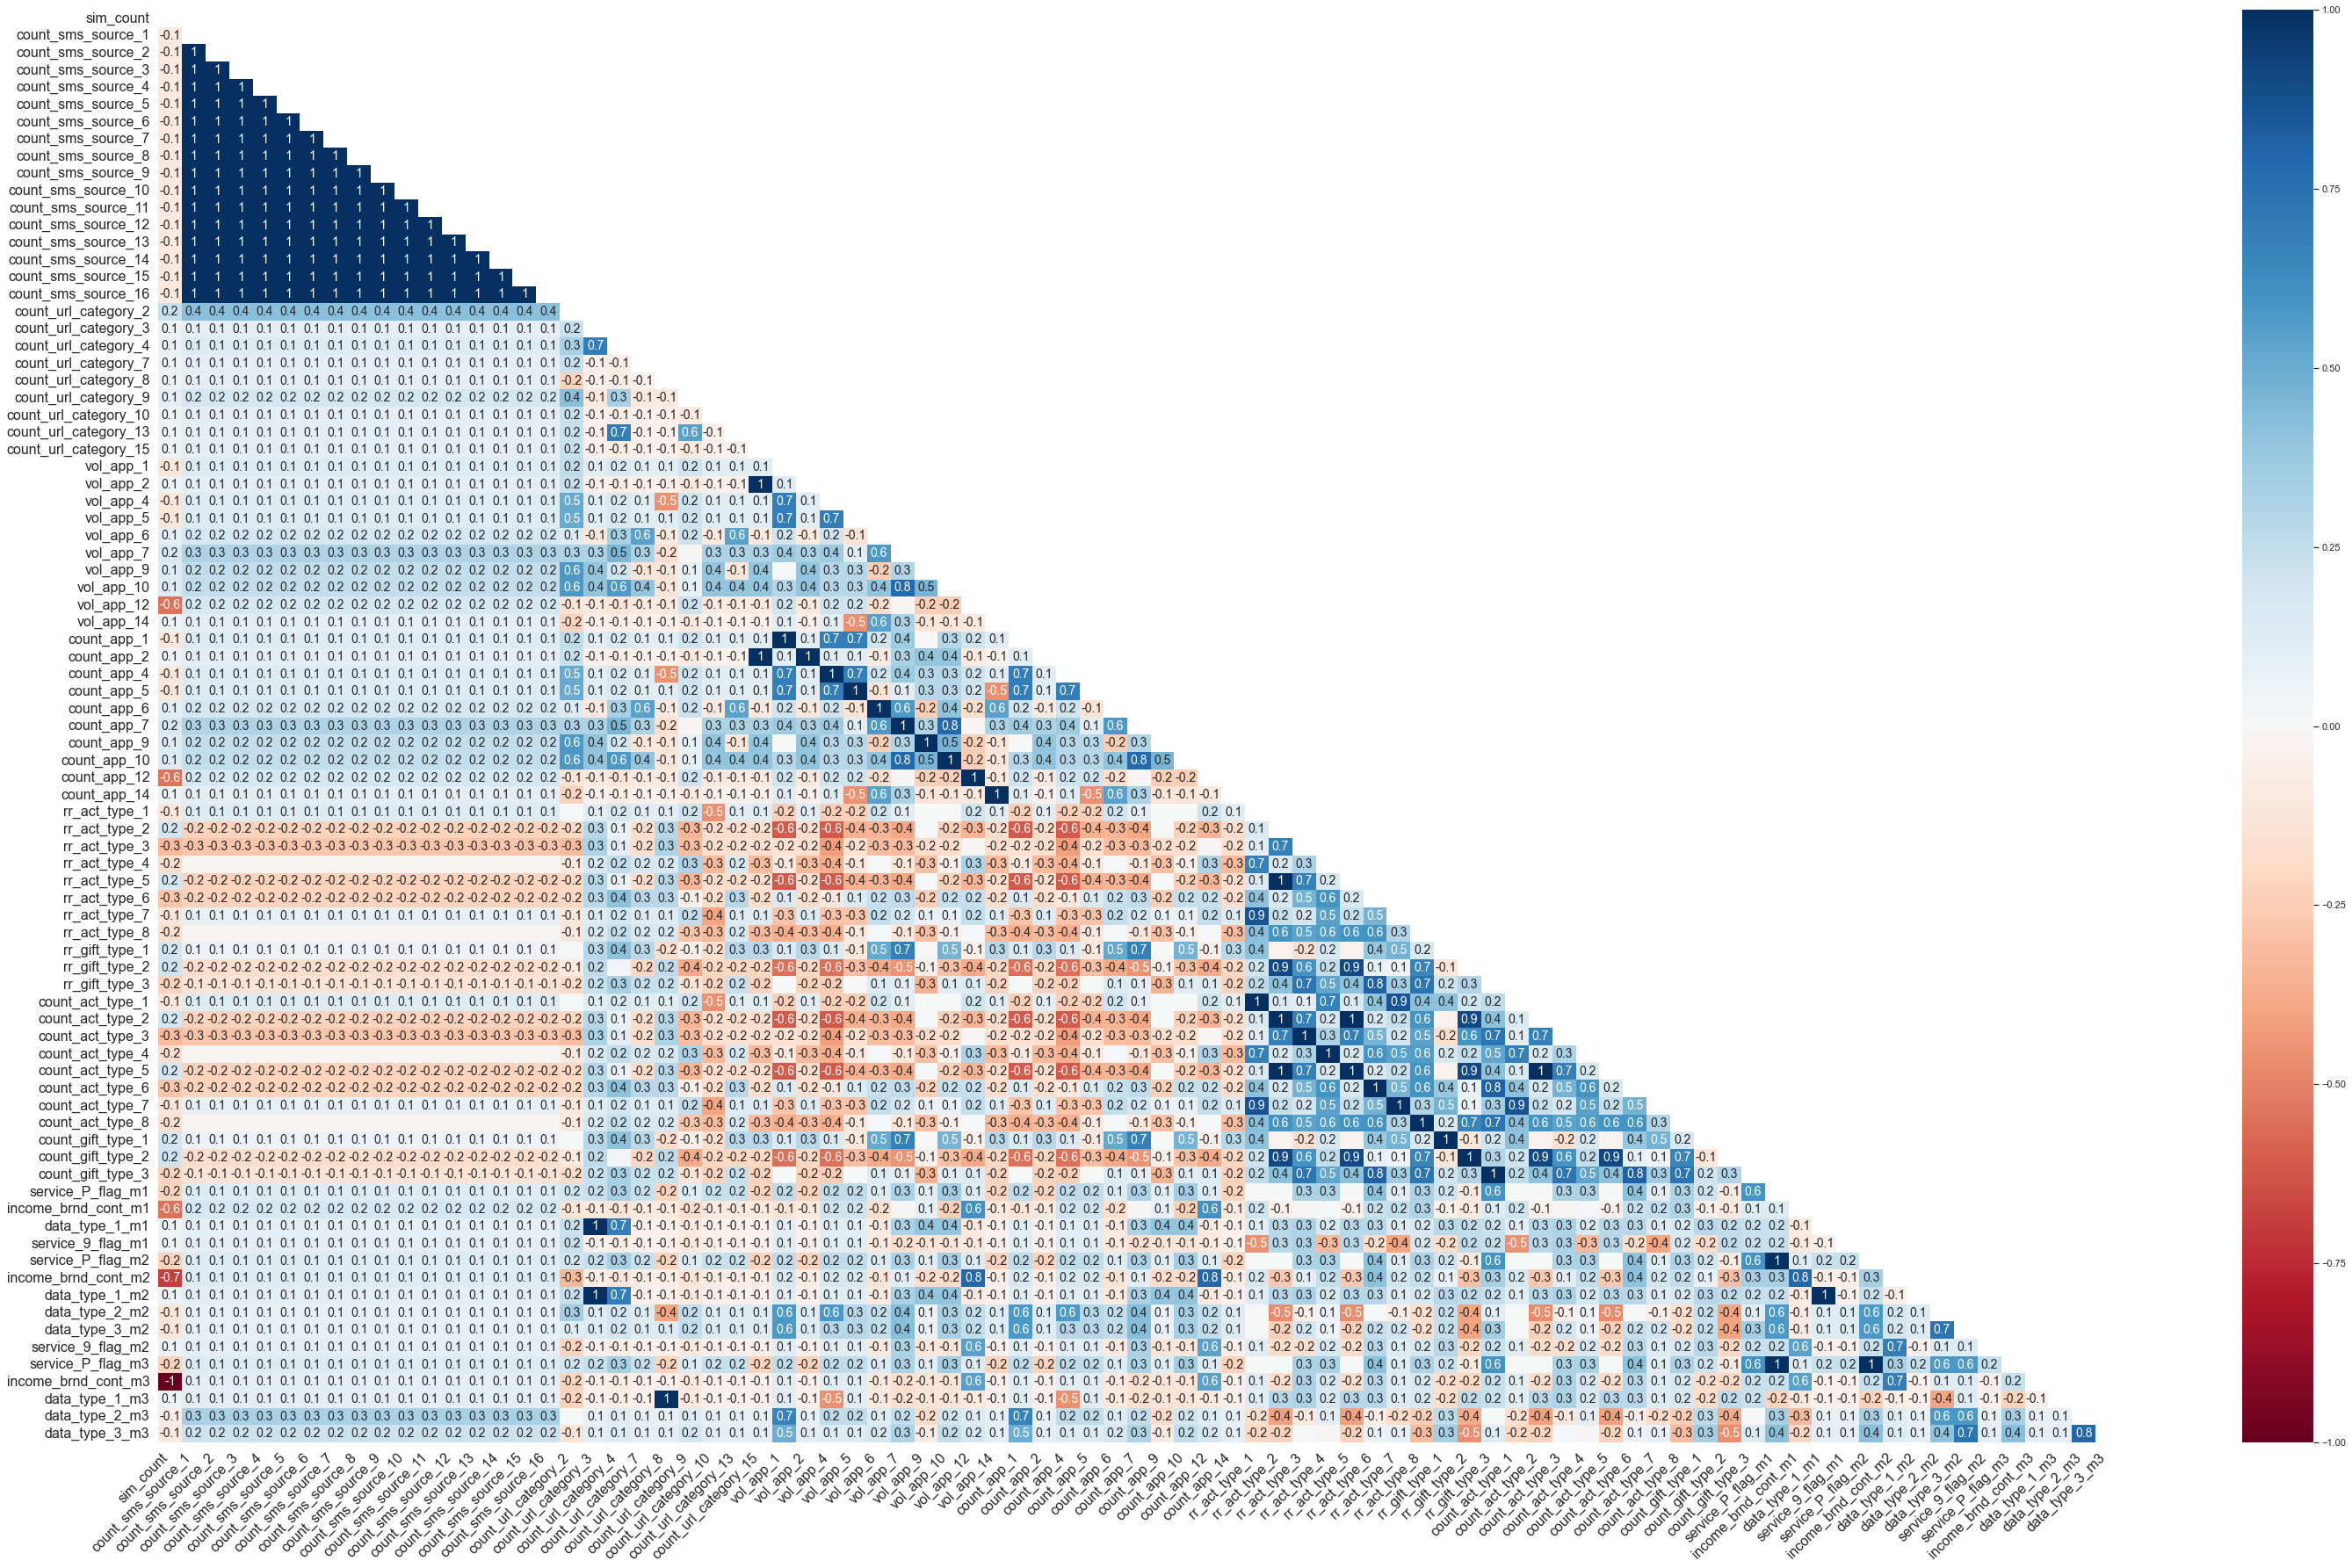

In [52]:
msno.heatmap(df[:20], figsize=(50,30))

In [30]:
# НЕ ЗАПУСКАЕМ ЭТО
# imputer = MissForest(random_state=42, n_estimators = 35,  oob_score = True, n_jobs= -1)
# df_KNNImputer = imputer.fit_transform(df)

Iteration: 0
Iteration: 1
Iteration: 2


Сохраняем изменения в таблицу и сохраняем саму таблицу, чтобы, в случае перезагрузки JupyterNotebook не пришлось использовать этот метод еще раз

In [45]:
# НЕ ЗАПУСКАЕМ ЭТО
# df_ForestImputer = df_KNNImputer
# df_ForestImputer = pd.DataFrame(df_ForestImputer, columns = df.columns)
# df_ForestImputer.to_csv('Train_music_ForestImputer.csv', index=False)

In [8]:
df_ForestImputer = pd.read_csv('Train_music_ForestImputer.csv')
df_ForestImputer

,id,target,device_type,manufacturer_category,os_category,sim_count,tp_flag,lt,block_flag,days_exp,...,service_5_count_m3,service_6_count_m3,service_7_cost_m3,service_7_flag_m3,service_8_count_m3,income_brnd_cont_m3,data_type_1_m3,data_type_2_m3,data_type_3_m3,service_9_flag_m3
0,4.810120e+10,0.0,7.0,592.0,3.0,2.0,0.0,0.632435,0.0,108.0,...,0.0,0.0,0.0,0.0,0.0,19.971334,127.895751,716.420311,114.566613,1.0
1,4.810425e+10,0.0,7.0,1057.0,3.0,2.0,0.0,0.540345,0.0,330.0,...,0.0,0.0,0.0,0.0,0.0,10.894140,234.292876,80.144736,14.630618,1.0
2,4.811813e+09,0.0,7.0,1057.0,3.0,2.0,0.0,0.951582,0.0,344.0,...,0.0,0.0,0.0,0.0,0.0,9.894929,0.018959,0.000977,57.100249,1.0
3,4.810105e+10,0.0,7.0,745.0,3.0,2.0,0.0,0.659047,0.0,361.0,...,0.0,0.0,0.0,0.0,0.0,8.183337,189.579215,118.776836,53.537855,1.0
4,4.830019e+09,0.0,7.0,1057.0,3.0,2.0,0.0,0.926471,0.0,199.0,...,0.0,0.0,0.0,0.0,0.0,2.217369,534.214973,1989.913944,29.685412,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,4.894477e+09,1.0,7.0,1057.0,3.0,2.0,0.0,0.707827,0.0,221.0,...,0.0,0.0,0.0,0.0,0.0,11.649066,522.172754,2286.497442,452.738112,1.0
19996,4.875985e+09,0.0,7.0,592.0,3.0,2.0,0.0,0.824135,0.0,355.0,...,0.0,0.0,0.0,0.0,0.0,2.159549,857.216847,5979.779220,265.482364,1.0
19997,4.811248e+09,0.0,7.0,728.0,3.0,1.0,0.0,0.924764,0.0,208.0,...,0.0,0.0,0.0,0.0,0.0,10.999666,196.408633,40.263622,0.071870,1.0
19998,4.896164e+09,0.0,7.0,1057.0,3.0,2.0,0.0,0.716732,0.0,324.0,...,0.0,0.0,0.0,0.0,0.0,14.756591,274.917012,28.008975,10.813313,1.0


(TODO: СДЕЛАТЬ KNNImputer и сравнить)

In [9]:
X = df_ForestImputer.drop(['target'], axis=1)
y = df_ForestImputer.target

In [10]:
X.drop(['id'], axis=1, inplace=True)
X

,device_type,manufacturer_category,os_category,sim_count,tp_flag,lt,block_flag,days_exp,service_1_flag,service_1_count,...,service_5_count_m3,service_6_count_m3,service_7_cost_m3,service_7_flag_m3,service_8_count_m3,income_brnd_cont_m3,data_type_1_m3,data_type_2_m3,data_type_3_m3,service_9_flag_m3
0,7.0,592.0,3.0,2.0,0.0,0.632435,0.0,108.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,19.971334,127.895751,716.420311,114.566613,1.0
1,7.0,1057.0,3.0,2.0,0.0,0.540345,0.0,330.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,10.894140,234.292876,80.144736,14.630618,1.0
2,7.0,1057.0,3.0,2.0,0.0,0.951582,0.0,344.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,9.894929,0.018959,0.000977,57.100249,1.0
3,7.0,745.0,3.0,2.0,0.0,0.659047,0.0,361.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8.183337,189.579215,118.776836,53.537855,1.0
4,7.0,1057.0,3.0,2.0,0.0,0.926471,0.0,199.0,1.0,25.0,...,0.0,0.0,0.0,0.0,0.0,2.217369,534.214973,1989.913944,29.685412,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,7.0,1057.0,3.0,2.0,0.0,0.707827,0.0,221.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.649066,522.172754,2286.497442,452.738112,1.0
19996,7.0,592.0,3.0,2.0,0.0,0.824135,0.0,355.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.159549,857.216847,5979.779220,265.482364,1.0
19997,7.0,728.0,3.0,1.0,0.0,0.924764,0.0,208.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,10.999666,196.408633,40.263622,0.071870,1.0
19998,7.0,1057.0,3.0,2.0,0.0,0.716732,0.0,324.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,14.756591,274.917012,28.008975,10.813313,1.0


In [11]:
selector_100 = SelectKBest(f_classif, k=100)
selector_100.fit(X, y)
# Get columns to keep and create new dataframe with those only
cols_100 = selector_100.get_support(indices=True)
df_new_100 = X.iloc[:,cols_100]

In [12]:
scaler = StandardScaler()
df_new_100 = pd.DataFrame(scaler.fit_transform(df_new_100), columns=df_new_100.columns)

In [13]:
def count(df_y):
    a = df_y[df_y == 0].count()
    b = df_y[df_y == 1].count()
    print("Will not download", a)
    print("Will download", b)
    print("Not download / Will download", a/b)
    return a/b

In [14]:
def makeScore(model):
    roc_auc = roc_auc_score(y_test, model.predict(X_test))
    f1 = f1_score(y_test, model.predict(X_test))
    accuracy = accuracy_score(y_test, model.predict(X_test))
    recall = recall_score(y_test, model.predict(X_test))
    precision = precision_score(y_test, model.predict(X_test))

    print(confusion_matrix(y_test, model.predict(X_test)))
    print("ROC_AUC: %.5f%%" % (roc_auc * 100.0))
    print("F1_score: %.5f%%" % (f1 * 100.0))
    print("Accuracy: %.5f%%" % (accuracy * 100.0))
    print("Recall: %.5f%%" % (recall * 100.0))
    print("Precision: %.5f%% "% (precision * 100.0))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df_new_100, y, test_size=0.2, random_state=42)

In [16]:
print("\n\tIMBALANCED CLASS\n")
difference = count(y_train)
model = XGBClassifier(scale_pos_weight = difference, use_rmm = 'true', eval_metric='mlogloss').fit(X_train, y_train)
print()
makeScore(model)


print("\n\tRANDOM OVERSAMPLING\n")
oversample = RandomOverSampler(random_state= 42, sampling_strategy = 'minority')
X_ros, y_ros = oversample.fit_resample(X_train, y_train)
model = XGBClassifier(use_rmm = 'true', eval_metric='mlogloss').fit(X_ros, y_ros)
count(y_ros)
print()
makeScore(model)


print("\n\tRANDOM UNDERSAMPLING\n")
undersample = RandomUnderSampler(random_state= 42, sampling_strategy = 'majority')
X_rus, y_rus = undersample.fit_resample(X_train, y_train)
model = XGBClassifier(use_rmm = 'true', eval_metric='mlogloss').fit(X_rus, y_rus)
count(y_rus)
print()
makeScore(model)


print("\n\tRANDOM OVERSEMPLING AND UNDERSAMPLING\n")
over = RandomOverSampler(random_state=42, sampling_strategy=0.2)
X_rous, y_rous = over.fit_resample(X_train, y_train)
under = RandomUnderSampler(random_state=42, sampling_strategy=0.9) # sampling_strategy = float - количество выборок в классе большинства после повторной выборки и количество выборок в классе меньшинства, соответственно.
X_rous, y_rous = under.fit_resample(X_rous, y_rous)
model = XGBClassifier(use_rmm = 'true', eval_metric='mlogloss').fit(X_rous, y_rous)
count(y_rous)
print()
makeScore(model)


	IMBALANCED CLASS

Will not download 14792
Will download 1208
Not download / Will download 12.245033112582782

[[3545  167]
 [ 225   63]]
ROC_AUC: 58.68804%
F1_score: 24.32432%
Accuracy: 90.20000%
Recall: 21.87500%
Precision: 27.39130% 

	RANDOM OVERSAMPLING

Will not download 14792
Will download 14792
Not download / Will download 1.0

[[3567  145]
 [ 224   64]]
ROC_AUC: 59.15799%
F1_score: 25.75453%
Accuracy: 90.77500%
Recall: 22.22222%
Precision: 30.62201% 

	RANDOM UNDERSAMPLING

Will not download 1208
Will download 1208
Not download / Will download 1.0

[[2601 1111]
 [  83  205]]
ROC_AUC: 70.62530%
F1_score: 25.56110%
Accuracy: 70.15000%
Recall: 71.18056%
Precision: 15.57751% 

	RANDOM OVERSEMPLING AND UNDERSAMPLING

Will not download 3286
Will download 2958
Not download / Will download 1.1108857336037863

[[3220  492]
 [ 144  144]]
ROC_AUC: 68.37284%
F1_score: 31.16883%
Accuracy: 84.10000%
Recall: 50.00000%
Precision: 22.64151% 


In [23]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [24]:
params = {'eta': [0.01, 0.1, 0.2, 0.3], 'gamma': np.arange(0.1, 0.6, 0.1), "n_estimators": np.arange(50, 201, 50)}
model = XGBClassifier(scale_pos_weight=difference, use_rmm='true', eval_metric='mlogloss')

grid = GridSearchCV(model, params, cv=kf, scoring='f1', n_jobs=-1)
grid.fit(df_new_100, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_dep...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None,
             

In [25]:
print("Найлучшее качество модели при", grid.best_params_)
print("Наилучшая оценка качества модели:", grid.best_score_)

Найлучшее качество модели при {'eta': 0.2, 'gamma': 0.5, 'n_estimators': 50}
Наилучшая оценка качества модели: 0.3304974083083055


In [26]:
steps = [('under', RandomUnderSampler(sampling_strategy = 'majority', random_state=42)), ('model', XGBClassifier(use_rmm = 'true', eval_metric='mlogloss'))]
pipeline = Pipeline(steps=steps)

params={
    'model__eta': [0.01, 0.1, 0.2, 0.3],
    'model__gamma':np.arange(0.1,0.6,0.1),
    'model__n_estimators': np.arange(50, 201, 50)
}
grid = GridSearchCV(pipeline, params, cv=kf, scoring='f1', n_jobs = -1)
grid.fit(df_new_100, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('under',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy='majority')),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      eval_metric='mlogloss',
                                                      gamma=None, gpu_id=N...
                                                      num_para

In [27]:
print("Найлучшее качество модели при", grid.best_params_)
print("Наилучшая оценка качества модели:", grid.best_score_)

Найлучшее качество модели при {'model__eta': 0.1, 'model__gamma': 0.30000000000000004, 'model__n_estimators': 50}
Наилучшая оценка качества модели: 0.28065406717266805


In [28]:
steps = [('over', RandomOverSampler(sampling_strategy = 'minority', random_state=42)), ('model', XGBClassifier(use_rmm = 'true', eval_metric='mlogloss'))]
pipeline = Pipeline(steps=steps)

params={
    'model__eta': [0.01, 0.1, 0.2, 0.3],
    'model__gamma':np.arange(0.1,0.6,0.1),
    'model__n_estimators': np.arange(50, 201, 50)
}
grid = GridSearchCV(pipeline, params, cv=kf, scoring='f1', n_jobs = -1)
grid.fit(df_new_100, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('over',
                                        RandomOverSampler(random_state=42,
                                                          sampling_strategy='minority')),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      eval_metric='mlogloss',
                                                      gamma=None, gpu_id=Non...
                                                      num_paral

In [29]:
print("Найлучшее качество модели при", grid.best_params_)
print("Наилучшая оценка качества модели:", grid.best_score_)

Найлучшее качество модели при {'model__eta': 0.1, 'model__gamma': 0.30000000000000004, 'model__n_estimators': 100}
Наилучшая оценка качества модели: 0.32700818878169663


In [30]:
steps = [('over', RandomOverSampler(random_state=42, sampling_strategy=0.2)), ('under', RandomUnderSampler(random_state=42, sampling_strategy=0.9)) ,('model', XGBClassifier(use_rmm = 'true', eval_metric='mlogloss'))]
pipeline = Pipeline(steps=steps)

params={
    'model__eta': [0.01, 0.1, 0.2, 0.3],
    'model__gamma':np.arange(0.1,0.6,0.1),
    'model__n_estimators': np.arange(50, 201, 50)
}
grid = GridSearchCV(pipeline, params, cv=kf, scoring='f1', n_jobs = -1)
grid.fit(df_new_100, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('over',
                                        RandomOverSampler(random_state=42,
                                                          sampling_strategy=0.2)),
                                       ('under',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=0.9)),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_c...
                                 

In [31]:
print("Найлучшее качество модели при", grid.best_params_)
print("Наилучшая оценка качества модели:", grid.best_score_)

Найлучшее качество модели при {'model__eta': 0.2, 'model__gamma': 0.30000000000000004, 'model__n_estimators': 200}
Наилучшая оценка качества модели: 0.33909550361777924


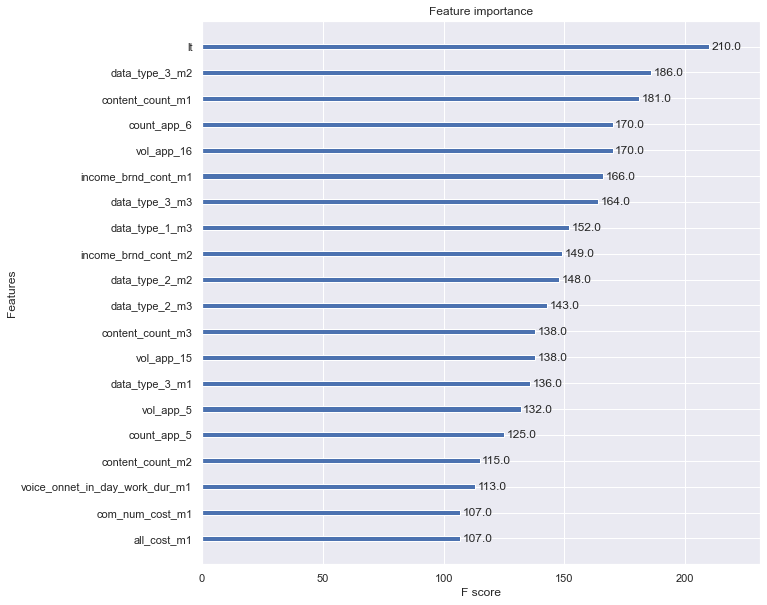

In [30]:
model = XGBClassifier(eta= 0.2, gamma= 0.3, n_estimators= 200, use_rmm= True, eval_metric='mlogloss')
model.fit(X_rous, y_rous)
ax = plot_importance(model, max_num_features=20)
fig = ax.figure
fig.set_size_inches(10, 10)